<a href="https://colab.research.google.com/github/Shamil2007/DataAnalysis/blob/main/Data-Cleaning/handling_outliers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#What is an Outlier?

**Statistical Definition:** An outlier is an observation that lies an abnormal distance from other values in a random sample from a population. In essence, it is a data point that is markedly different from the rest of the sample, raising suspicions that it was generated by a different mechanism.

**Analogy:** Consider a peaceful neighborhood of single-family homes. A new, slightly larger house built on a double lot is not an outlier; it's just a bigger house. An outlier would be a 50-story skyscraper suddenly erected in the middle of the street. It is a fundamentally different structure that doesn't belong to the same distribution as the family homes. It demands investigation: Is this a mistake? Or is it a genuine, paradigm-shifting event?

#Why Do Outliers Occur? (The Root Causes)
**Understanding the why is the first step in deciding the how of handling them.**

- Data Entry Errors: Simple human mistakes during data transcription. (e.g., typing 1000 instead of 100, adding an extra zero, misplacing a decimal point).

- Measurement Errors: Instrument malfunctions, sensor drift, or system glitches. (e.g., a faulty thermometer reading -200°C, a scale maxing out and defaulting to an error code).

- Sampling Errors: Accidentally including a data point from a population outside the study's scope. (e.g., Including data from an elephant in a study of housecat anatomy, or a corporate transaction in a dataset of individual consumer purchases).

- Natural Variation (Genuine Outliers): These are the most interesting cases. They represent rare but authentic events. They are not mistakes; they are the "black swans." (e.g., a billionaire in an income survey, a once-in-a-century storm in climatic data, a fraudulent transaction among legitimate ones).

#Why Must We Handle Them? (The Impact)
**Outliers are not just a nuisance; they actively distort the analytical process.**

**Descriptive Statistics:** They exert a disproportionate "pull" on summary statistics. A single extreme value can render the mean useless and inflate the standard deviation, giving a false impression of high variability in the data.

**Statistical Models:**

- Parametric Models (e.g., Linear Regression): These models often rely on least squares estimation. A single outlier can drastically tilt the regression line towards itself, compromising the model's fit for the remaining 99% of the data.

- Distance-Based Models (e.g., K-Means, K-NN): K-Means clustering centroids can be dragged towards outliers, creating poor clusters. K-NN classifications can be skewed by an outlier that is the nearest neighbor.

- Algorithmic Performance: Ultimately, this leads to models that generalize poorly to new, clean data. The model learns the "noise" of the outliers instead of the "signal" of the core distribution.

**Data Visualization:** Outliers can compress the scale of graphs, making it impossible to discern patterns and relationships within the normal range of the data. All you see is the outlier.

#How to Identify Outliers: The Diagnostic Toolkit

**Visual Methods:**

- **Box Plots (The Workhorse):** A box plot visualizes the Interquartile Range (IQR). The "whiskers" typically extend to Q1 - 1.5 * IQR and Q3 + 1.5 * IQR. Any data point beyond these whiskers is traditionally considered a potential outlier. It provides an immediate, intuitive visual flag.

- **Scatter Plots:** Essential for identifying multivariate outliers—points that are not unusual in any single dimension but have an unusual combination of values (e.g., a person with very low income but very high credit card spending).

- **Histograms & KDE Plots:** Will show a long, thin tail stretching away from the main body of the distribution, or a separate, isolated bar.



**Statistical Methods:**

- **Z-Score:** Measures how many standard deviations a point is from the mean.
z_i = (x_i - μ) / σ
A common rule is to flag points where |Z-score| > 3. Limitation: It assumes a normal distribution and is itself influenced by the outliers (μ and σ are not robust).

- **IQR Method (The Robust Choice):** This is often superior for real-world, non-normal data.

    Calculate IQR: IQR = Q3 - Q1

    Define lower and upper bounds: Lower Fence = Q1 - 1.5 * IQR, Upper Fence = Q3 + 1.5 * IQR

    Any point outside these bounds is a potential outlier.

**Advanced ML Techniques: For complex, high-dimensional data.**

- **Isolation Forest:** Works on the principle that outliers are few and different, making them easier to "isolate" than regular points.

- **DBSCAN:** A clustering algorithm that can mark points that do not belong to any dense cluster as outliers.

#How to Handle Outliers: A Strategic Framework

**First, investigate. Never auto-drop. Ask: error, sampling issue, or genuine rare event?**

**Strategy 1 — Remove**

- When: Conclusive errors (typos, broken sensors) and no correct value available.

- How: Filter out rows outside robust bounds or those with proven erroneous conditions (e.g., negative income).

- Risk: If genuine, removal biases the dataset.

**Strategy 2 — Impute (Capping/Winsorizing)**

- When: Suspected error without true value; or genuine value that destabilizes models.

- How: Cap at robust percentiles (e.g., 5th/95th) or IQR bounds.
Example: df[col] = df[col].clip(lower, upper)

- Benefit: Keep the row; reduce outlier influence.

**Strategy 3 — Transform**

- When: Genuine skew (e.g., incomes, counts).

- How: log / sqrt / Box-Cox / Yeo-Johnson to compress tails and stabilize variance.

**Strategy 4 — Separate Modeling**

- When: Outliers are the signal (fraud, anomalies, rare failures).

- How: Split workflow: model the majority and build a dedicated anomaly model for the rare class.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
np.random.seed(42)
n = 50000

scores_main = np.clip(75 + 10*np.random.randn(n), 50, 100)
scores = scores_main.copy()

scores[[5, 123]] = 1000
scores[[77, 511]] = -25

# Annual_Income: right-skewed + genuine high earners + a few negative errors
# Start with log-normal (median ~ exp(mu) when sigma small)
mu, sigma = 10.8, 0.5                     # rough median ≈ exp(10.8) ≈ 49k
incomes = np.random.lognormal(mean=mu, sigma=sigma, size=n)

# Add a few very high, genuine earners (natural long tail)
incomes[[2, 98, 401]] *= 8                # push into very high tail

incomes[[50, 350]] = -12000               # impossible negative income

df_outliers = pd.DataFrame({
    "Test_Scores": scores,
    "Annual_Income": incomes
})

df_outliers

,Test_Scores,Annual_Income
0,79.967142,51487.949699
1,73.617357,47474.399439
2,81.476885,631174.040020
3,90.230299,105494.655380
4,72.658466,69107.840691
...,...,...
49995,75.567990,43799.931513
49996,74.750771,36868.441767
49997,80.000848,60149.748439
49998,77.652154,44110.545711


#The Step-by-Step Cleaning Walkthrough

In [3]:
print("--- Dataset Info ---")
df_outliers.info()

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Test_Scores    50000 non-null  float64
 1   Annual_Income  50000 non-null  float64
dtypes: float64(2)
memory usage: 781.4 KB


In [4]:
print("\n--- Descriptive Statistics ---")
df_outliers.describe()


--- Descriptive Statistics ---


,Test_Scores,Annual_Income
count,50000.000000,50000.000000
mean,75.032335,55660.246844
std,11.505329,29863.532062
min,-25.000000,-12000.000000
25%,68.213600,35068.541624
50%,75.017653,49112.307091
75%,81.772244,68765.493458
max,1000.000000,631174.040020


**Output Interpretation:**

The .describe() output is a massive red flag.
1. For Test_Scores, the min is -25 and the max is 1000, while the mean is ~78—this is a clear sign that the mean is being skewed by extreme values.
2. Similarly, for Annual_Income, the min is -50000 and the max is very high, with a mean that might not represent the typical person. The standard deviation is huge for both, another classic symptom of outliers.

#Visualize (see before/after)

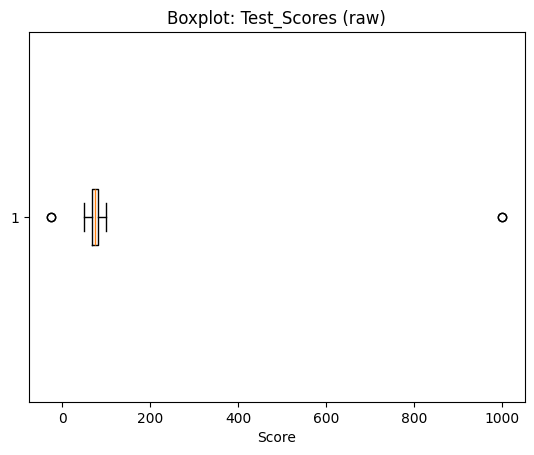

In [5]:
plt.figure()
plt.boxplot(df_outliers["Test_Scores"].dropna(), vert=False)
plt.title("Boxplot: Test_Scores (raw)")
plt.xlabel("Score")
plt.show()

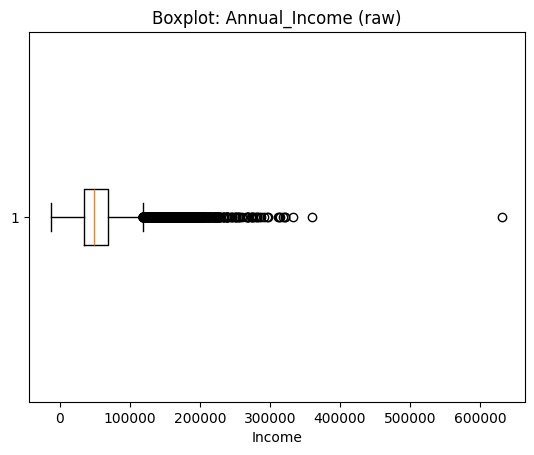

In [6]:
plt.figure()
plt.boxplot(df_outliers["Annual_Income"].dropna(), vert=False)
plt.title("Boxplot: Annual_Income (raw)")
plt.xlabel("Income")
plt.show()

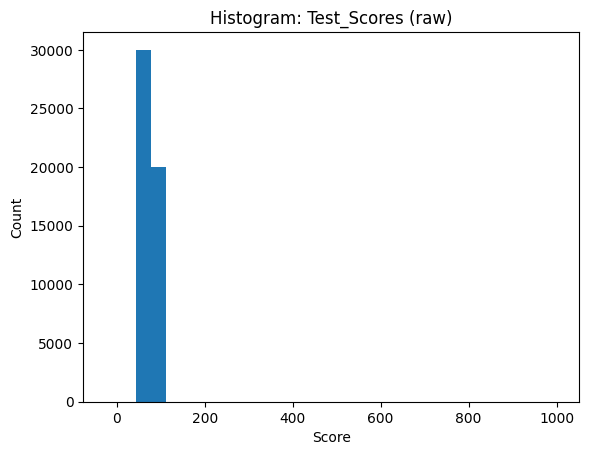

In [7]:
# Histograms
plt.figure()
plt.hist(df_outliers["Test_Scores"].dropna(), bins=30)
plt.title("Histogram: Test_Scores (raw)")
plt.xlabel("Score")
plt.ylabel("Count")
plt.show()

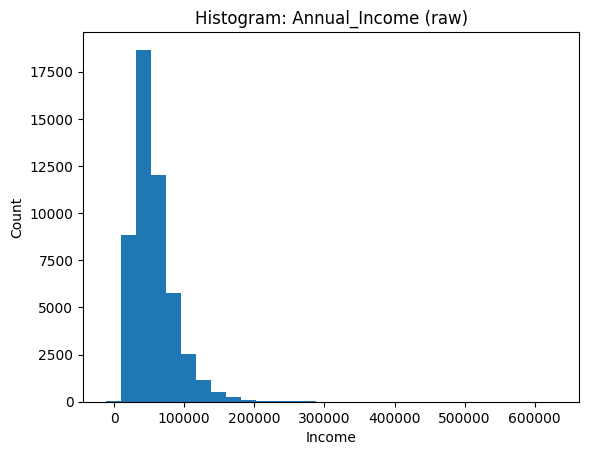

In [8]:
plt.figure()
plt.hist(df_outliers["Annual_Income"].dropna(), bins=30)
plt.title("Histogram: Annual_Income (raw)")
plt.xlabel("Income")
plt.ylabel("Count")
plt.show()

#Diagnose (IQR & Z-scores)

In [9]:
def diagnose_outliers_iqr(column, df):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"--- IQR Diagnosis for {column} ---")
    print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
    print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
    print(f"Number of outliers detected: {len(outliers)}")
    return outliers

# Diagnose each column
test_score_outliers = diagnose_outliers_iqr('Test_Scores', df_outliers)
income_outliers = diagnose_outliers_iqr('Annual_Income', df_outliers)

# Let's look at the actual outlier values for Test_Scores
print("\nOutlier values for Test_Scores:")
print(test_score_outliers['Test_Scores'].values)

--- IQR Diagnosis for Test_Scores ---
Q1: 68.21359990175785, Q3: 81.77224409955815, IQR: 13.558644197800305
Lower Bound: 47.87563360505739, Upper Bound: 102.11021039625861
Number of outliers detected: 4
--- IQR Diagnosis for Annual_Income ---
Q1: 35068.54162413033, Q3: 68765.4934578753, IQR: 33696.95183374497
Lower Bound: -15476.886126487123, Upper Bound: 119310.92120849276
Number of outliers detected: 1935

Outlier values for Test_Scores:
[1000.  -25. 1000.  -25.]


**Diagnosis Interpretation:** The IQR method will successfully flag the -25, 1000, and 999 values in Test_Scores. For Annual_Income, it will flag the -50000 and the very high genuine incomes. This is our cue to apply different strategies.

**Strategy for Test_Scores (Errors):** Imputation (Capping)
Since these are clear errors, we will cap them to the IQR bounds to reduce their influence without removing the entire row (which might contain good data in other columns).

In [10]:
# Calculate IQR bounds for capping
Q1_test = df_outliers['Test_Scores'].quantile(0.25)
Q3_test = df_outliers['Test_Scores'].quantile(0.75)
IQR_test = Q3_test - Q1_test
lower_cap_test = Q1_test - 1.5 * IQR_test
upper_cap_test = Q3_test + 1.5 * IQR_test

print(f"Capping Test_Scores to between {lower_cap_test} and {upper_cap_test}")

# Apply capping
df_cleaned = df_outliers.copy() # Always work on a copy!
df_cleaned['Test_Scores_Capped'] = df_cleaned['Test_Scores'].clip(lower=lower_cap_test, upper=upper_cap_test)

Capping Test_Scores to between 47.87563360505739 and 102.11021039625861


**Strategy for Annual_Income (Skewed Distribution):** Log Transformation
The negative value is an error and must be handled first. We'll cap negative values to a very small positive number (e.g., 1) to make it log-transformable. The genuine high incomes will be handled by the log.

In [11]:
# 1. First, handle the erroneous negative value by capping it to a minimum sensible value, say $1000.
min_income = 1000
df_cleaned['Annual_Income_NoNeg'] = df_cleaned['Annual_Income'].clip(lower=min_income)

# 2. Apply log transformation to handle the right-skew and genuine high-income outliers.
# We add 1 to avoid log(0) if our minimum cap were ever 0.
df_cleaned['Annual_Income_Log'] = np.log1p(df_cleaned['Annual_Income_NoNeg'])

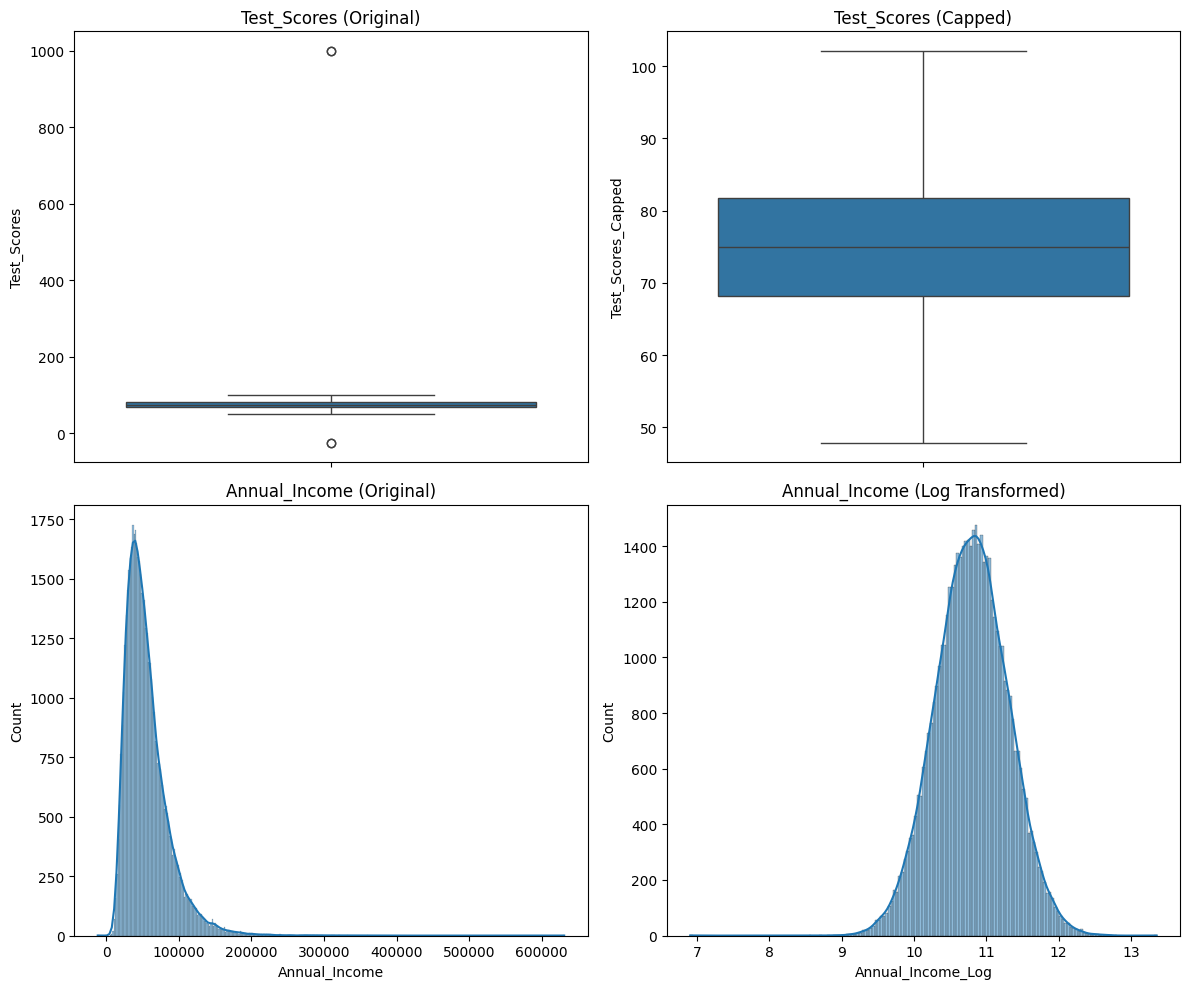


--- Summary Statistics After Cleaning ---
       Test_Scores_Capped  Annual_Income_Log
count        50000.000000       50000.000000
mean            74.999335          10.801184
std              9.889731           0.501661
min             47.875634           6.908755
25%             68.213600          10.465088
50%             75.017653          10.801885
75%             81.772244          11.138472
max            102.110210          13.355339


In [12]:
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Before and After for Test Scores
sns.boxplot(data=df_cleaned, y='Test_Scores', ax=axes[0, 0])
axes[0, 0].set_title('Test_Scores (Original)')
sns.boxplot(data=df_cleaned, y='Test_Scores_Capped', ax=axes[0, 1])
axes[0, 1].set_title('Test_Scores (Capped)')

# Before and After for Income (using histograms to see distribution change)
sns.histplot(df_cleaned['Annual_Income'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Annual_Income (Original)')
sns.histplot(df_cleaned['Annual_Income_Log'], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Annual_Income (Log Transformed)')

plt.tight_layout()
plt.show()

print("\n--- Summary Statistics After Cleaning ---")
print(df_cleaned[['Test_Scores_Capped', 'Annual_Income_Log']].describe())

**Validation Result:** The new boxplot for *Test_Scores_Capped* will be clean, with no points beyond the whiskers. The histogram for *Annual_Income_Log* will show a beautiful, approximately normal distribution instead of a long right tail. The *.describe()* output will now show a mean and standard deviation that are truly representative of the central tendency and spread of the data. The data is now model-ready.

You have not just written code; you have exercised professional judgment. You investigated the cause, chose a strategy tailored to that cause, and validated the result. This is the mark of a true data scientist. Go forth and analyze with confidence.